# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

***
## Training
Run the agent's training process.

In [1]:
from TD3.td3_agent import TD3
from task import Takeoff
import pandas as pd
import numpy as np
import sys

initial = np.array([0., 0., 0.1, 0., 0., 0.])
target_height = 10.
takeoff = Takeoff(target_height, i_pose=initial, run_t=15.)
td3 = TD3(takeoff, lra=0.001, lrc=0.001, db=0.0000016)

Using TensorFlow backend.


In [2]:
num_episodes = 500
episodes = np.arange(1, num_episodes + 1)
episode_rewards = []
best_reward = -np.inf

for episode in episodes:
    state = td3.reset_episode() # start a new episode
    episode_r = 0
    while True:
        action = td3.act(state)
        next_state, reward, done = takeoff.step(action)
        abs_e, loss = td3.step(action, reward, next_state, done)
        state = next_state        
        episode_r += reward
        if done:
            episode_rewards.append(episode_r)
            best_reward = max(best_reward, episode_r)
            update_statement = "\rEpisode ={:4d}, reward = {:7.3f} (highest = {:7.3f}), loss = {:7.3f}, abs_err = {:7.3f}"
            print(update_statement.format(episode, episode_r, best_reward, loss, abs_e), end='')
            break
            
    sys.stdout.flush()

Episode = 500, reward = 600.211 (highest = 691.801), loss =   0.478, abs_err =   0.611

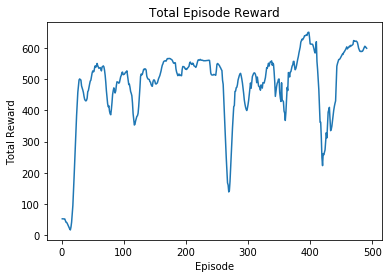

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def rolling(data, num=10) :
    ret = np.cumsum(data, dtype=float)
    ret[num:] = ret[num:] - ret[:-num]
    return ret[num - 1:] / num

rolling_reward = rolling(episode_rewards)
episodes = np.arange(1, len(rolling_reward)+1)

plt.plot(episodes, rolling_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Episode Reward')
_ = plt.ylim()

***
## Testing
A single run of the trained agent will be completed and recorded below. 

In [31]:
import csv
import numpy as np

# Setup
test_labels = ['time', 'reward', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed']
results = {x : [] for x in test_labels}
file_output = 'data.txt'
done = False

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(test_labels)
    test_state = td3.reset_episode()
    while True:
        test_state = np.reshape(test_state, [-1, 2])
        test_action = td3.actor_local.model.predict(test_state)
        next_state, reward, done = takeoff.step(list(test_action[0]))
        test_state = next_state
        test_rotor = list(test_action[0] * 900.)
        test_rew = [reward]
        test_time = [takeoff.sim.time]
        test_pose = list(takeoff.sim.pose)
        test_v = list(takeoff.sim.v)
        test_ang_v = list(takeoff.sim.angular_v)
        to_write = np.concatenate((test_time, test_rew, test_pose, test_v, test_ang_v, test_rotor))
        for ii in range(len(test_labels)):
            results[test_labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Total Episode Reward:  617.12


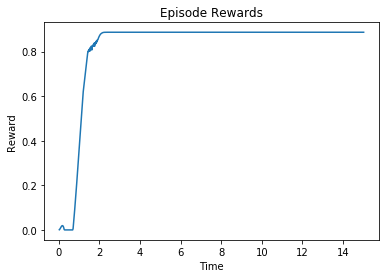

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['reward'])
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Episode Rewards')
_ = plt.ylim()

print('Total Episode Reward: {:7.2f}'.format(np.sum(results['reward'])))

Settled on   11.12


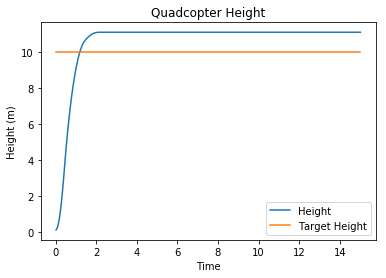

In [54]:
%matplotlib inline
print('Settled on {:7.2f}'.format(results['z'][len(results['z'])-1]))
target_height = np.full(len(results['time']), 10.)
plt.plot(results['time'], results['z'], label='Height')
plt.plot(results['time'], target_height, label='Target Height')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.title('Quadcopter Height')
plt.legend()
_ = plt.ylim()

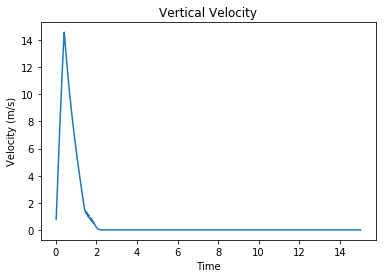

In [34]:
plt.plot(results['time'], results['z_velocity'])
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.title('Vertical Velocity')
_ = plt.ylim()

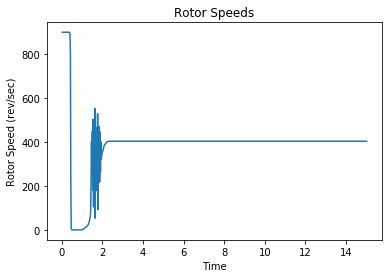

In [35]:
plt.plot(results['time'], results['rotor_speed'])
plt.xlabel('Time')
plt.ylabel('Rotor Speed (rev/sec)')
plt.title('Rotor Speeds')
_ = plt.ylim()

##  Reflections

In [38]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def reward_functions(d=None, s=None, func=None):
    if func == 'distance':
        return (1 - d)
    elif func == 'speed':
        return (1 - s)
        
d = np.linspace(0., 1., 1000)
s = np.linspace(0., 1., 1000)
D, S = np.meshgrid(d, s)  

dist_reward = reward_functions(D, S, 'distance')
speed_penalty = reward_functions(D, S, 'speed')
reward_function = dist_reward * speed_penalty

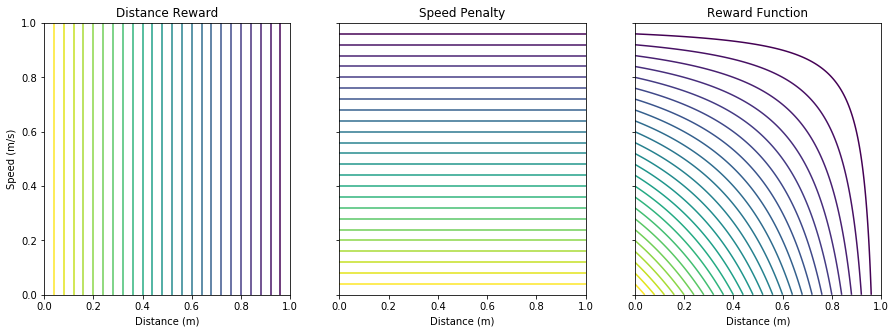

In [45]:
f, (dist, speed, rew) = plt.subplots(1, 3, sharex='all', sharey='all', squeeze=True)
f.set_size_inches(15, 5)

dist.contour(D, S, dist_reward, 30)
dist.set_xlabel('Distance (m)')
dist.set_ylabel('Speed (m/s)')
dist.set_title('Distance Reward')

speed.contour(D, S, speed_penalty, 30)
speed.set_xlabel('Distance (m)')
speed.set_title('Speed Penalty')

rew.contour(D, S, reward_function, 30)
rew.set_xlabel('Distance (m)')
rew.set_title('Reward Function');

**Distance Reward:** ($1 - distance$)  
&emsp;&ensp;&nbsp;**Speed Penalty:** ($1 - speed$)
>**Reward Function:** $(1 - distance) * (1 - speed)$
***
**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?
  
**Answer**: What I wanted the quadcopter to do was to learn to reach a given target height starting from the floor and stay there. At first I had a reward function that did not take into consideration the speed at which it reached the target, and the quadcopter would reach the target height as fast as possible but fly past; even if it completely turned off its rotors once it hit the target, inertia would keep make it continue on past the target height. Therefore, I had to incorporate the speed of the quadcopter in the reward function; I needed a function to reward the quadcopter as it got closer but also penalize the quadcopter the faster it went. In order to keep the reward values within a [0-1] range, the distance and speed have to be standardized by dividing both, distance and speed, by the starting distance to the target; a standardized reward function helps prevent an exploding gradient which causes divergence, because there will not be unproportianetely large weight changes of the Q network. So, for example, if the quadcopter starts at ground height, 0.0 meters, and the target height is 50.0 meters in the air, all the future quadcopter's distances to the target and its speed will be divided by a constant starting distance of 50. meters; since the speed function and distance function are given the same importance, keeping the distance and speed values proportional to one another is very important for the reward function to converge. If values are unproportionately scaled, one value is going to increase much faster than the other one and will cause divergence during training. The left graph shows a contour of the distance function, $(1.0 - distance)$, which gives a higher reward as the quadcopter gets closer to the target height; a linear increase in reward as distance to target reaches zero is more than enough in terms of capturing the fact the you want to quadcopter to get closer to the target. In order to discourage the quadcopter to fly at high speeds, a speed penalty function that linearly decreases in value the faster the quadcopter flies is needed. The middle plot shows this function, $(1.0 - speed)$, and it can be noted that lower speeds correspond to higher values, yellow contour lines represent values closer to 1. This second function alone, however, does not emphasize that the quadcopter should get closer to the target, since it rewards low speeds regardless of the distance to the target. Neither one of these functions can be solely responsible for making the quadcopter learn to speed up when it is far away from the target and slow down when its closer. Therefore, by simply multipying the linear distance reward function with the linear speed penalty function, we acquire a final reward function that captures the essence of reaching the target as fast as possible but also, linearly slowing down as distance decreases. The plot on the right shows the resulting contour plot after multiplying both linear functions, rewards of 1.0 are seen only if the both the distance and speed become really low. In conclusion, in order for the linear functions to work, the most important part of setting up the task is the proportionate standardization of the speed and distance to target values; make sure to divide both by the starting distance to height, which is a constant.

***
**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.  
  
**Algorithm Overview and Agent Components**
> I used a variation of a deep deterministic policy gradient, or DDPG, algorithm proposed in this [academic paper](https://arxiv.org/pdf/1802.09477.pdf) which uses a third critic and target critic network, a delayed update of the actor networks and added noise to the target policy's predicted next actions; this DDPG variant is known as the Time Delayed 3 algorithm, or TD3. In a DDPG algorithm, the actor network chooses the actions to take given the current state and the critic learns to associate that action-state pair with the reward received after acting on the environment with the actor's action. In order for the networks to take into account the effect velocity has on the reward function, the state passed to the actor and critic networks included the standardized velocity of the quadcopter and its height; the action is a single rotor speeds, since the goal is to just go straight up until a target position and hover once it reaches the target. In order to improve stability of the whole learning process, target actor and target critic networks were used which get updated with a fraction of the main networks' weights; without target networks the learning process experiences a high level of variance from update to update and often leads to divergence. The TD3 algorithm adds noise to the predicted action of the actor's target network when predicting the next Q value, since the target actor network is constantly being updated and will later predict a slightly different action given the same state; in order to account for this small change in predicted actions from time step to time step, a small amount of noise will be added to the predicted action which will, in turn, help the critic networks "bootstrap" similar state-action pairs together. The third target critic and target critic networks proposed in the paper help to reduce the overestimation bias accumulated by the target critic network by taking the minimum predicted Q value of the two critic target networks, and using that Q value to set the Q_target which will be used to train the main critic networks; this overstimation bias is unavoidable as the critic networks' accumulate a bias error every time the critic network sees an action-state pair and can be seen in the Bellman equations, and, further, the actor taking actions following the overestimated Q gradients leads the actor to choose actions associated with the overestimated Q values which further adds to the critics' overestimation. Finally, the TD3 algorithm uses a time delayed update to the actor networks, because delaying the actor update allows the critic networks to converge to a more accurate Q estimate with a lower variance, since the same reward-action-state coupling will be seen by the critics. Finally, in order to avoid a local optima, increase generalization of similar state-action pairs and push the actor networks to try actions it has not learned, I apply the Ornstein-Uhlenbeck process to generate action correlated nosie.
  
**Actor Network**
> The parameters for all of the previous named processes are as follow. For the actor networks, I gave them a learning rate of 0.001, since anything bigger than this would lead to a massive change of reward from episode to episode which would forget a lot of the things learned from the previous episode, and anything smaller would make the actor stay in a single range without reward improvement. Since the mapping of the rewards to the state is not linearly separable, the actor network is composed of two hidden, dense layers with a 'relu' activation function with 400 and 300 nodes, respectively. I chose these number of layers and nodes because the even though for a human the task of reaching a certain height might seem simple, the mapping of what actions to take given a certain state is highly complex due to the continuous nature of the states and actions. The output layer had a 'sigmoid' activation function in order to restrain the output to the possible actions, which cannot be negative. In order to maximize reward the actor would perform gradient descent given the gradient of the Q_values w.r.t. its actions and the gradient of the actions w.r.t. the actor's network weights. 

**Critic Network**
> For the critic networks, I used a similar neural network architecture with Adam as the optimizer and the same learning rate of 0.001, but now we have the states and actions as inputs as opposed to only the states. Therefore, I started the first layer with 400 nodes and took the states concatenated with the actions as input, and this layer was followed by a second hidden layer containing 300 nodes. Both hidden layers use the 'relu' activation function. Finally, the output layer condenses its inputs to a single Q_value, which it tries to accurately predict by minimizing the mean squared error loss between the Q_value it predicted and the minimum discounted Q_value predicted by the critic target networks plus rewards.  

**Prioritized Experience Replay**
> In the DDPG agent, I defined the prioritized experience buffer to be of size 10,000 and sample a minibatch of 32 every time it learnt. For the prioritized buffer, I used a power of 0.4 to be applied to the TD error of the critic network; the closer the power is to 0 the more the buffer resembles a uniform distribution, and the closer to 1, the more priority it gives to the experiences with a high TD error and consequently it becomes greedier in selecting experiences with high TD error. This allows experiences with a reward higher than what is usually expected to be seen more often and allow the networks to converge on those experiences, until it is accurately estimated. However, there is also a downside, experiences with a lower than predicted reward are also highly prioritized which could lead to divergent behavior by making the networks focus on those low reward state actions and unlearn what it learned from the high reward state actions. In order to minimize the accumulated bias from repeatedly sampling the same experiences, importance sample weights are implemented. For the importance sampling weights, I used a power of 0.4 which would linearly increase to 1 as training went on; the closer the importance sampling weights' power is to 1, the lower the importance the critic network gives to those experiences. Since the importance sampling weights are inversely proportional to the priority, or TD error, of the experience, a weight's power close to 0 would mean that the weights would become 1 and each experience would be treated the same by the critic network even if they were greedily chosen. Therefore, as training progresses and convergence begins, the weight's power linearly increases to 1 which makes the weights better represent the inversely proportional priority. The data structure chosen to hold the 10,000 experience's priorities is a binary heap where old experiences were replaced as the binary heap got full.

**OU Noise**
> For the Ornstein-Uhlenbeck noise process, the mean is set at zero for both the target and local actor network actions. For both the local actor and target actor predicted actions, a mu value of 0.45, theta of 0.15 and sigma of 0.15 is used when calling for noise. An action value of 0.45 causes the quadcopter to hover which is what we ultimately want the noise to revert to once it has reached the target height. A theta value of 0.15 is not too small to the point where it does not influence the noise to revert to the mu value of 0.45, but it is also not too big to cause the noise to instantly revert to a certain value given an action. Finally, a sigma value of 0.15 is used to keep the volatility down; a low sigma value is increasingly important during the later stages of convergence when the quadcopter is required to hover, since any slight noise can change the quadcopter velocity. The only difference between the noise applied to the local actor's actions and the target actor's actions is the clipping of noise to the target actor's actions; the noise applied to the target actor's action will be clipped to a value of 0.5. Adding noise to the target actor's actions allows the critic network to account for the variation of the next actions predicted by the actor target network as it updates at between time steps; in effect, the critic is better able to generalize the Q values of similar states even when actions vary by a certain level of noise. Using a simplistic Gaussian noise does not account for the desired continuous, smooth aspect of rotor speeds. After experimenting with it, it can be noted that random Gaussian noise impairs the convergence of the agent, since it does not revert to a mu value of 0.45 which allows the quadcopter to hover.     

**Other Learning Parameters**
> I chose a common gamma value of 0.99, in order to only discount the expected reward slightly enough to allow for the most recent experience's reward to be important but not too discounted to the point where the agent forgets past experiences quickly. For the delayed actor networks' updates, the networks will get updated every time the time step is divisible by 2; therefore, if a training session has 1,000 time steps per episode, the actor networks will be updated for 500 of those. Finally, a tau value of 0.005 was chosen to update the target networks, because a value bigger than 0.005 would lead to very large oscillations in the reward and not much progress in the overall learning of the agent, and a value smaller than 0.005 would prevent the agent from going anywhere as the target networks would change too slowly in either direction.  

Last 10 Episodes:  599.78


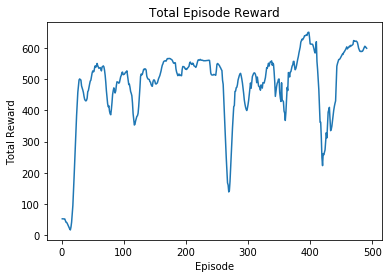

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def rolling(data, num=10) :
    ret = np.cumsum(data, dtype=float)
    ret[num:] = ret[num:] - ret[:-num]
    return ret[num - 1:] / num

rolling_reward = rolling(episode_rewards)
episodes = np.arange(1, len(rolling_reward)+1)

plt.plot(episodes, rolling_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Episode Reward')
_ = plt.ylim()

last_idx = len(rolling_reward)-1
last_10 = rolling_reward[last_idx]
print('Last 10 Episodes: {:7.2f}'.format(last_10))

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: The task of flying to a target height and hovering at the target height proved to be difficult the closer the quadcopter got to the target height; since the quadcopter's reward increased the faster it got to the target height, it approached the target at a high velocity, and the quadcopter would not be able to slow down in time. Once the quadcopter would pass the target height, the reward would begin decreasing, and in order to account for that the learning agent would adjust the weights in order to slow down the quadcopter. However, that would then cause a drop in overall reward, because the quadcopter was now passing more time in lower reward states. In turn, the agent would then again increase the speed of the quadcopter, and the cycle would repeat. I believe adjusting the reward function or simply running the training for longer might reduce the variance between episodes, because, as it can be seen from the smoothed plot, the reward drops do not reach the same lows as the previous ones. I would say it was a pretty good final performance, but it could definitely be improved upon. The biggest opporunity for growth, I belive, is in the slight modification of the reward function.

***  
**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: Everything about this project was very hard, because there were so many hyperparameters that affected the learning of the DDPG agent, and if any one of those was slightly off, the agent would not learn. The hardest part was definitely putting into code what I read and learned from many of the papers that had dealt with a DDPG agent before. The prioritized experience replay, since there is not many examples of other machine learning engineers implementing this into their reinforcement learning code, was one of the hardest to implement in my code. One of the main problems was that the output importance sampling weights of the experience replay were not compatible with the Keras training methods; for example, trying to figure out how to incorporate those weights with the Keras' optimizer losses without getting NaN outputs. Another hard part was figuring out how to get the gradients of the actor's model weights incorporated not only the actions, but also with the gradients of the critic network, because Keras optimizers did not offer an input gradient argument to input the action gradients obtained from the critic network; I fixed this by intertwining the Tensorflow Adam optimizer into the Keras backend function, since Tensorflow's Adam optimizer had an apply gradients method that the Keras optimizers did not. In terms of the quadcopter's behavior, it was interesting how it began to learn to stop flying past the target; at first the quadcopter would fly straight past the target, but as the agent learned, the quadcopter would still pass the height but now it would begin slowing down once it passed the target. After countless hours spent on researching and experimenting with different tactics, I was able to build an agent that learned to reach the target height and hover at the target height until time expired.  